# Clustering

## Question 1.1: K-Means (25 points)
The following dataset has 5 clusters. Generate a dataset with 5 means in two dimensions, with means $\mu$ and variance $\sigma$ defined as follows:
* $\mu_1 = (-4,4)$, $\sigma_1 = 1$
* $\mu_2 = (-4,-4)$, $\sigma_2 = 1$
* $\mu_3 = (4,4)$, $\sigma_3 = 1$
* $\mu_4 = (4,-4)$, $\sigma_4 = 1$
* $\mu_5 = (0,0)$, $\sigma_5 = 1$
 
Name your features ```x1``` and ```x2```.
 
Generate 100 points in each cluster and plot each cluster with a different color.  Use the same format we usually use with the cluster id as the ```label``` field and also set the cluster in a field called ```cluster```.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import collections
import random

In [2]:
def plot_clusters(dataset):
    x1 = []
    x2 = []
    target = []
    for row in dataset:
        x1.append(row["features"]["x1"])
        x2.append(row["features"]["x2"])
        if type(row["cluster"]) is int:
            target.append(row["cluster"])
        elif type(row["cluster"]) is list:
            target.append(row["cluster"][0] * 2 + row["cluster"][1])

    #plt.figure(figsize=(30, 30), dpi= 80, facecolor='w', edgecolor='k')
    fig, ax = plt.subplots(figsize=(7, 5), dpi= 100, facecolor='w', edgecolor='k')
    ax.scatter(x1, x2, marker='.', c=target)
    ax.set_xlabel(r'$X_1$', fontsize=15)
    ax.set_ylabel(r'$X_2$', fontsize=15)
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    ax.grid(True)
    #fig.tight_layout()
    plt.show()

In [3]:
def random_point(cluster, sigma, label):
    x1, x2 = cluster
    point = {}
    point["features"] = {}
    point["features"]["x1"] = np.random.normal(x1, sigma)
    point["features"]["x2"] = np.random.normal(x2, sigma)
    point["cluster"] = cluster
    point["label"] = label
    return point

def create_cluster_dataset():
    n = 100
    clusters = [[-4,4], [-4,-4], [4,4], [4,-4], [0,0]]
    dataset = []

    for index, cluster in enumerate(clusters):
        for i in range(n):
            dataset.append(random_point(cluster, 1, index + 1))

    return dataset

dataset = create_cluster_dataset()
print(dataset[0])

{'features': {'x1': -4.848201800428026, 'x2': 2.788784737568177}, 'cluster': [-4, 4], 'label': 1}


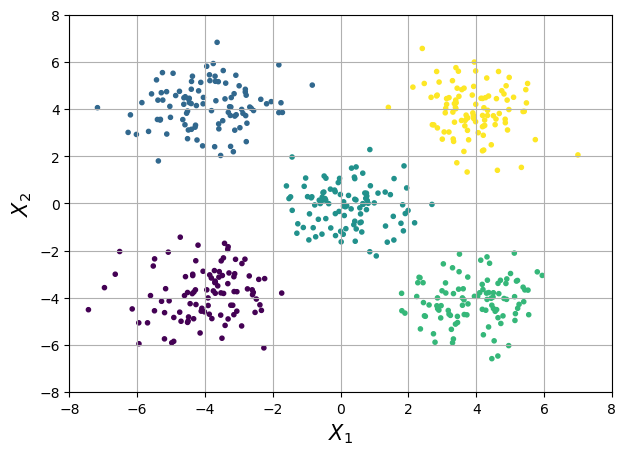

In [4]:
def test_11_1():
    dataset = create_cluster_dataset()
    assert(dataset)
    assert(500 == len(dataset))
    plot_clusters(dataset)

test_11_1()

In [5]:
def test_11_2():
    dataset = create_cluster_dataset()
    counter = {}
    for x in dataset:
        counter[tuple(x["cluster"])] = counter.get(tuple(x["cluster"]), 0) + 1

    assert(5 == len(counter))
    assert(all(v == 100 for v in counter.values())) 
  
    lcounter = {}
    for x in dataset:
        lcounter[x["label"]] = lcounter.get(x["label"], 0) + 1

    assert(5 == len(lcounter))
    assert(all(v == 100 for v in lcounter.values()))

test_11_2()

In [6]:
def test_11_3():
    dataset = create_cluster_dataset()
    clusters = collections.defaultdict(list)
    for x in dataset:
        clusters[x["label"]].append(x)
    means = [[-4,4], [-4,-4], [4,4], [4,-4], [0,0]]
    for i in range(5):
        key = list(clusters.keys())[i]
        assert(clusters[key])
        assert(100 == len(clusters[key]))
        m1 = sum(point["features"]["x1"] for point in clusters[key]) / 100.0
        m2 = sum(point["features"]["x2"] for point in clusters[key]) / 100.0
        assert(abs(m1 - means[i][0]) < 0.5)
        assert(abs(m2 - means[i][1]) < 0.5)   

test_11_3()

## Question 1.2 (25 points)

Generate $k = 5$ random means, each within the min and max of each feature value.

In [7]:
def init_cluster(data, k):
    means = collections.defaultdict(dict)
    x1 = list(map(lambda x: x["features"]["x1"], data))
    x2 = list(map(lambda x: x["features"]["x2"], data))
    #print(x1)
    #print(x2)
    x1min, x1max = min(x1), max(x1)
    x2min, x2max = min(x2), max(x2)
    rand = random.Random()
    for i in range(k):
        means[i]["x1"] = x1min + (x1max - x1min) * rand.random()
        means[i]["x2"] = x2min + (x2max - x2min) * rand.random()
    return means

In [8]:
def test_12_1():
    dataset = create_cluster_dataset()  
    means = init_cluster(dataset, 5)
    assert(5 == len(means))
    assert(2 == len(means[0]))
    for i in range(5):
        assert(i in means)
    assert(all(abs(m["x1"]) < 10 for m in means.values()))#, "Expected mean of x1 in [-10, 10]")
    assert(all(abs(m["x2"]) < 10 for m in means.values()))#, "Expected mean of x2 in [-10, 10]")

test_12_1()

## Question 2.1: (10 points)
We will now implement the k-means algorithm to recover the clusters above. Return the means and plot the obtained clustering. Compare your discovered means to the known means.

Starting from a randomly initialized set of clusters defined by a set of means, we will iteratively refine our estimate of the clustering. At each step, we update the means, assign clusters, and update means from the assigned clustering. We denote candidate cluster membership by the binary vector $z_{i,j} = 1$ if example $i$ belongs to cluster $j$. Use an ```Array``` for a row of z.

Start by setting the $z$ vector by assigning finding the mean closest to each point in the datset. Set the candidate cluster in the ```cluster``` field in each row. 

In [9]:
def assign_cluster(data, means):
    indices = [i for i in range(len(means))]
    z = []
    for point in data:
        cluster_index = min(indices, key = lambda i: (means[i]["x1"] - point["features"]["x1"]) ** 2 + 
                                                     (means[i]["x2"] - point["features"]["x2"]) ** 2)
        point["cluster"] = cluster_index
        zi = [0.0] * len(means)
        zi[cluster_index] = 1.0
        z.append(zi)
    return z

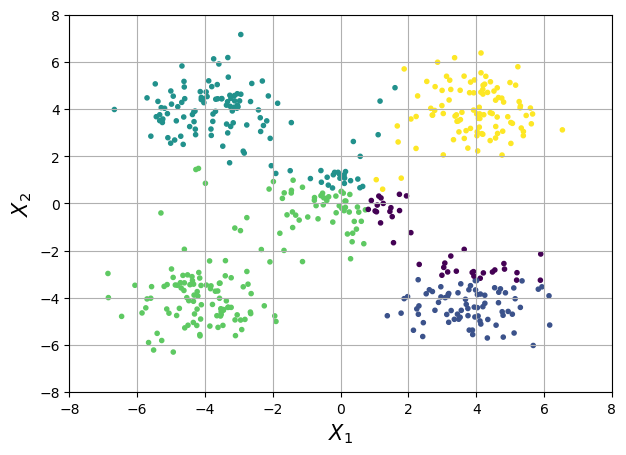

In [10]:
def test_21_1():
    dataset = create_cluster_dataset()  
    means = init_cluster(dataset, 5)
    z = assign_cluster(dataset, means)
    assert(500 == len(z))
    assert(all(len(zi) == 5 for zi in z)) # "Must set a value for each cluster")
    assert(all(zi.count(0.0) == 4 and zi.count(1.0 == 5) for zi in z))
    #"Must set only one cluster to 1.0 and all others to 0.0 (not an integer)"
    plot_clusters(dataset)

test_21_1()

## Question 2.2: (5 points)
Given the $z$ vector and the dataset, calculate the means for each cluster determined by $z$. 

In [11]:
def calculate_means(z, data):
    means = collections.defaultdict(dict)
    cnt = [0] * len(z[0])
    
    # collect points belongs to same class in z, eg: z[i] = [1.0, 0.0], then i belongs index0
    for i in range(len(data)):
        for j in range(len(z[i])):
            if z[i][j] == 1.0:
                cnt[j] += 1
                means[j]["x1"] = means[j].get("x1", 0.0) + data[i]["features"]["x1"]
                means[j]["x2"] = means[j].get("x2", 0.0) + data[i]["features"]["x2"]

    for j in range(len(cnt)):
        if cnt[j] > 0.0:
            means[j]["x1"] /= cnt[j]
            means[j]["x2"] /= cnt[j]
        else:
            means[j]["x1"] = 0.0
            means[j]["x2"] = 0.0
    return means

In [12]:
def test_22_1():
    dataset = create_cluster_dataset()  
    means1 = init_cluster(dataset, 5)
    z = assign_cluster(dataset, means1)

    assert(500 == len(dataset))
    assert(500 == len(z))

    means2 = calculate_means(z, dataset)
    assert(5 == len(means2))
    for i in range(5):
        assert(i in means2)

    for i in range(5):
        assert(abs(means2[i]["x1"] - means1[i]["x1"]) > 1e-5) # "Expected means to change")
        assert(abs(means2[i]["x2"] - means1[i]["x2"]) > 1e-5) # "Expected means to change") 

    assert(all(abs(fm["x1"]) < 10 for fm in means2.values())) # "Expected mean of x1 in [-10, 10]")
    assert(all(abs(fm["x2"]) < 10 for fm in means2.values())) # "Expected mean of x2 in [-10, 10]")

test_22_1()

## Question 2.3: (5 points)
As we iteratively refine our means for the clusters, we need to terminate after some criterion. Stop when the cluster distances are less than $\tau = 0.001$ and plot the convergence. First, let's calculate the distance between the set of $k$ means, using squared distance. Use the following formula for the termination criteria:

#  $\frac{1}{k} \sum_{k} \left\lVert \mu^{(k)}_t - \mu^{(k)}_{t - 1} \right\rVert^2 \le \tau$

In [13]:
def cluster_dist(m0, m1):
    dist = 0.0
    for i in m0.keys():
        for k in m0[i]:
            dist += (m0[i][k] - m1[i][k]) ** 2 
    return dist / len(m0)

In [14]:
def test_23_1():
    m0 = {0: {"x": 1.0, "y": 2.0}, 1: {"x": 2.0, "y": 3.0}}
    m1 = {0: {"x": 2.0, "y": 2.0}, 1: {"x": 3.0, "y": 4.0}}

    assert(0.0 == cluster_dist(m0, m0))
    assert(0.0 == cluster_dist(m1, m1))
    assert(1.5 == cluster_dist(m0, m1))

test_23_1()

## Question 2.4: (10 Points)

We are now ready to complete the $k$-means clustering algorithm. Given a dataset, the number of clusters desired, $k$, and the termination condition, $\tau$, initialize the means, update the clusters, and refine the estimates until converged. To ensure that the process terminates, stop after 100 iterations. 

When complete, return an array of distances from the current means to the previous means as well as the last vector of means.

In [15]:
def k_means(data, k, tau = 0.001):
    dists = []
    curr_means = init_cluster(data, k)
    for _ in range(100):
        prev_means = curr_means
        z = assign_cluster(data, prev_means)
        curr_means = calculate_means(z, data)
        dist = cluster_dist(prev_means, curr_means)
        dists.append(dist)
        if dist < tau: break

    z = assign_cluster(data, curr_means)
    return [dists, curr_means, z]

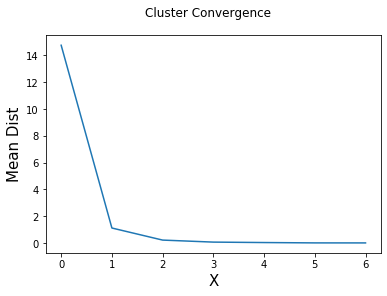

In [16]:
def test_24_1():
    dataset = create_cluster_dataset()    
    dists, means, z = k_means(dataset, 3, 0.001)

    assert(len(dists) > 3)
    assert(dists[1] < dists[0])
    assert(dists[-1] < dists[1])
    assert(dists[-1] <= 0.001)
    iters = [i for i in range(len(dists))]
    
    fig, ax = plt.subplots()
    ax.plot(iters, dists)
    ax.set_xlabel('X', fontsize=15)
    ax.set_ylabel('Mean Dist', fontsize=15)
    plt.suptitle("Cluster Convergence")
    plt.show()

test_24_1()

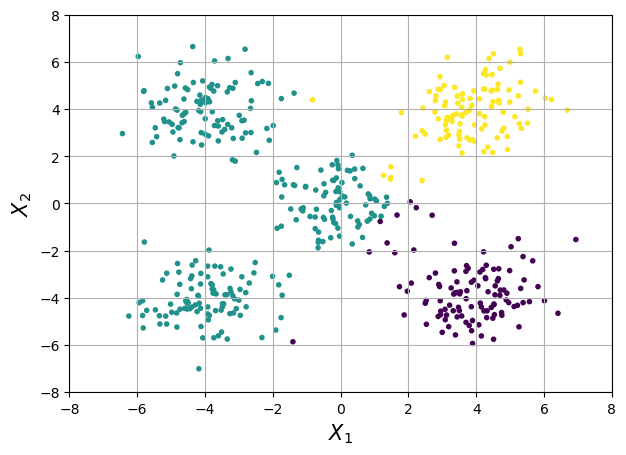

In [17]:
def test_25_1(k):
    dataset = create_cluster_dataset()    
    dists, means, z = k_means(dataset, k, 0.001)

    assert(k == len(means))
    assert(len(dists) > 3)
    assert(dists[1] < dists[0])
    assert(dists[-1] < dists[1])
    assert(dists[-1] <= 0.001)
    plot_clusters(dataset)

test_25_1(3)

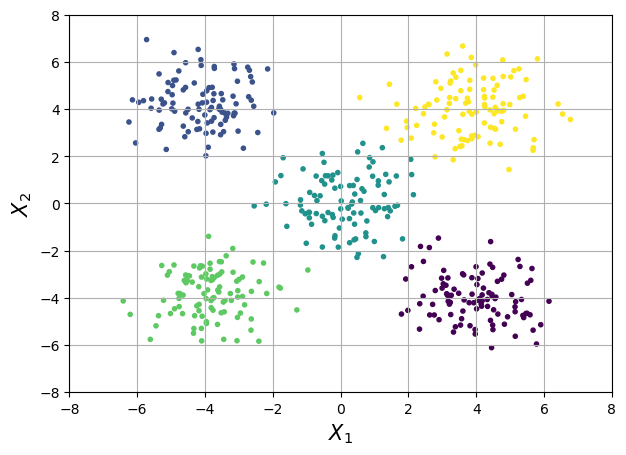

In [18]:
test_25_1(5)

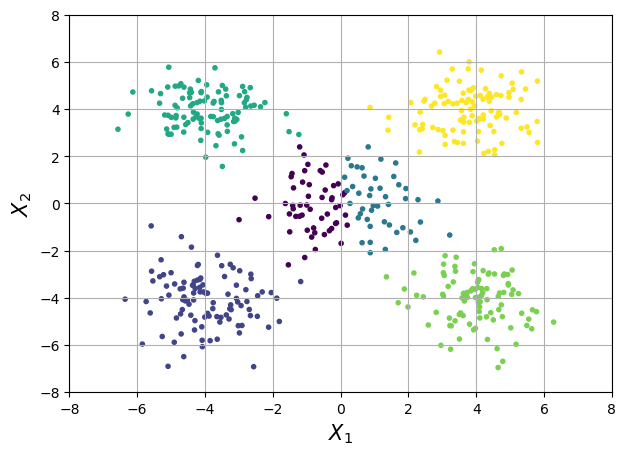

In [19]:
test_25_1(6)

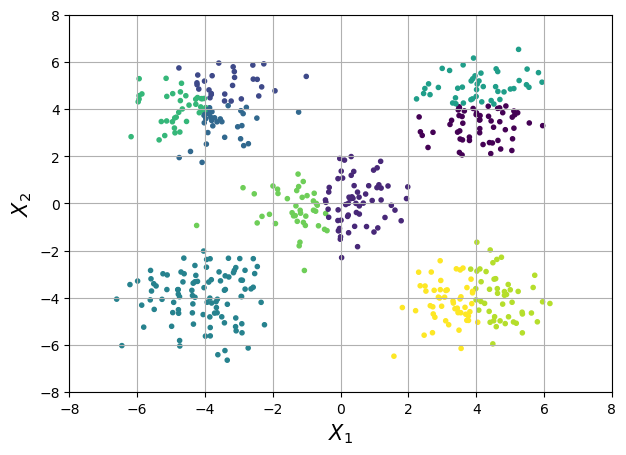

In [20]:
test_25_1(10)

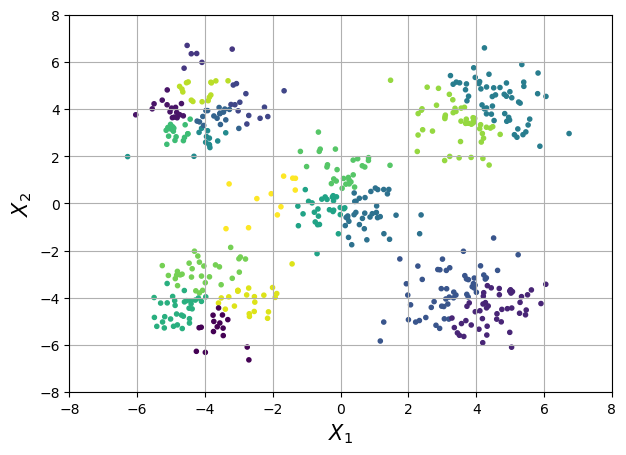

In [21]:
test_25_1(20)

## Question 2.6 (5 points)

Answer some questions about clustering. 

1. Which of cluster values fit the data best (visually)
 * (A) $k = 3$
 * (B) $k = 5$
 * (C) $k = 6$
 * (D) $k = 10$
 * (D) $k = 20$ 
1. When you set $k$ to a higher value than the ideal number of clusters what happens?
 * (A) Algorithm terminates because ideal number of clusters is a required argument
 * (B) All clusters except the ideal number are set to zero
 * (C) Clusters are split into smaller pieces
 * (D) Clusters are regularized out
1. Go back and try running the clusterings again. You may see that the obtained clusters are different in a few runs. Why? Is $k$-means is sensitive to the initialization?
 * (A) No, it is because the data is being randomly re-generated each time
 * (B) Yes, but only when $k$ is more than the ideal number of clusters
 * (C) No, $k$-means is a convex optimization problem and therefore insensitive to starting point
 * (D) Yes, it is sensitive to the initially guessed means
1. As discussed in the lecture, which of the following captures the biggest difference between $k$-means and the EM-algorithm for gaussian mixture models (with unit variance)?
 * (A) In the EM-algorithm, the $z$ vector is a probability and not just 0 or 1
 * (B) In the EM-algorithm, the means are selected from a normal distribution rather than a uniform distribution
 * (C) The K-means algorithm has no E step or M step, but EM has both 
 * (D) No difference, the algorithms are the same
1. Which datasets are well-suited to $k$-means clustering?
 * (A) All datasets, $k$-means is a low-bias algorithm
 * (B) High-dimensional, sparse vectors with multi-modal normal distributions
 * (C) Low-dimensional, dense vectors with multi-modal normal distributions
 * (D) Only toy datasets like those in this assignment
 